In [1]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict
from nltk.corpus import wordnet as wn
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import os
import csv

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Wordclouds</p>

In this section, we will analyze the characters background and personality based on solely plain text form the wiki pages and their dialogue.

For this we will look at to different sets: the dialogue and the wiki pages. From the dialogue we would like to extract information about how the characters talk, which could provide us with some insights about their personality traits. From the wiki pages we just expect to retrieve more "biographical" information and facts about who they are and their story. We will again only focus on the 5 main characters, that have the most lines, Michael, Dwight, Pam, Jim and Andy. It is important to point out that the dialogue is not complete! Hence we don't have all of the information and the results could be a bit biased.

For this, we will use wordclous for visualization. For both we need to pre-process the text into tokens in the following way:
- Remove punctuation  
- Generating the tokens
- Remove all the stopwords  
- Lemmatize
- Remove "infiltrated" words that we don't want

In [2]:
sw = stopwords.words('english')
tk = nltk.WordPunctTokenizer()

def tokenize_text(text):
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation.replace("'","")))
    
    #Generating the tokens
    tokens = tk.tokenize(text)
    
    #Removing all the stopwords
    new_tokens = [token.lower() for token in tokens if token not in sw]
    
    #Generating the lemmatizer and returning the output
    wnl = nltk.WordNetLemmatizer()
    output = [wnl.lemmatize(t) for t in new_tokens]
    
    return output

def tokenize_sentences(sentences):
    return tokenize_text(" ".join(sentences))

## On the dialogue

For the dialogue we will use TF-IDF to extract the most relevant words that are used. We first "stitch" all of the lines said by each character in every episode into one big text. We will have, for every character, a number of documents/text equivalent to the episodes they appear in. To compute the TF we just get the frequency of each word.

The TF is computed previously by first getting every word count. Then, for each term count (TC) needs to be divided with the number of words in the document, and then get the term frequency is acquired (TF). After this, the IDF is computed of all the words across the communities with nltk's built-in method <code>.idf()</code>. To get the TF-IDF we just multiply the TF of every word by its IDF.

#### Processing and utility functions
In this part we load the dataset with the character lines. We make a few functions that we will use later, to extract the total lines per character, the lines per character in every season and for every episode. We also only keep those lines that were actually aired.

In [3]:
script_path = "Data/the-office-lines-script.xlsx"
df_dialog = pd.read_excel(script_path, index_col = "id")

In [4]:
df_dialog.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [5]:
# We remove the parenthetical. That is, the text into parenthesis that provides directions for the characters.
parentheticals_regex = r"(\[.*?\])"

def remove_parentheticals(line):
    line = str(line)
    parentheticals = re.findall(parentheticals_regex,line)
    
    for parenthetical in parentheticals:
        line = line.replace(parenthetical, "")
    
    return line

In [6]:
def get_character_lines_per_episode(character, remove_par = True):

    df_aired_lines = df_dialog.loc[df_dialog.deleted == False]
    df_character = df_aired_lines.loc[df_aired_lines.speaker == character]
    
    character_season_lines = {}

    for season in df_character.season.unique():
        df_season = df_character.loc[df_character.season == season]
        character_episode_lines = {}
        
        for episode in df_season.episode.unique():
            df_episode = df_season.loc[df_season.episode == episode]           
            character_episode_lines[episode] = list(df_episode.line_text)
            
            if remove_par:
                character_episode_lines[episode] = [remove_parentheticals(line) for line in list(df_episode.line_text)]
        
        character_season_lines[season] = character_episode_lines
        
    return character_season_lines

In [7]:
def get_character_lines_per_season(character):
    character_season_lines = get_character_lines_per_episode(character)       
    return {season:[line for episode in episodes.values() for line in episode] for (season, episodes) in character_season_lines.items()}

In [8]:
def get_character_lines_series(character):  
    dialog = get_character_lines_per_season(character)
    return [line for season in dialog.values() for line in season]

In [9]:
def un_pack_episode_lines(character):
    episode_lines = get_character_lines_per_episode(character)   
    return [lines for episode in episode_lines.values() for lines in episode.values()]

#### Computing TF-IDF

We define the functions necessary for TF-IDF and compute it for every word. We tried with several hyper-parameters, but ended up using tc_idf(), since it was the one that produced better outputs. For example, if a character had a line singing, then the lyrics will come up in the wordcloud even if it's not representative.

In [10]:
def tc(token_list):
    tc = {}
    tokens = [word for tokens in token_list for word in tokens]
    for key, value in nltk.FreqDist(tokens).items():
        tc[key] = value
    return tc

def idf(texts):
    text = nltk.TextCollection(texts)
    idf = {}
    for word in text:
        idf[word] = text.idf(word)
    return idf

def idf_log(token_list):
    unique_tokens = np.unique([word for tokens in token_list for word in tokens])
    idf = {}
    n_documents = len(token_list)
        
    for word in unique_tokens:
        n_documents_with_word = [1 for document in token_list if word in document]
        idf[word] = np.log((n_documents)/(len(n_documents_with_word)+1))
        
    return idf

def tc_logidf(tokens):
    tc_ = tc(tokens)
    idf_log_ = idf_log(tokens)  
    return {word:tc_[word]*math.ceil(idf_log_[word]) for word in tc_.keys()}
        
def tc_idf(tokens):
    tc_ = tc(tokens)
    idfs = idf(tokens)
    tc_idf = {}
    tokens = [word for token_list in tokens for word in token_list]
    for word in tokens:
        tc_idf[word] = int(math.ceil(idfs[word])) * tc_[word]
    return tc_idf

In [11]:
characters_to_analyze = ["Michael","Jim", "Dwight", "Pam", "Andy"]
def get_tokens():
    characters_tokens = {}
    
    for character in characters_to_analyze:
        texts = un_pack_episode_lines(character)
        tokens = [tokenize_sentences(text) for text in texts]

        characters_tokens[character] = tokens
    return characters_tokens

In [12]:
'''
characters_tokens = get_tokens()
with open('Data/characters_tokens.pickle', 'wb') as handle:
    pickle.dump(characters_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

"\ncharacters_tokens = get_tokens()\nwith open('Data/characters_tokens.pickle', 'wb') as handle:\n    pickle.dump(characters_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [13]:
with open('Data/characters_tokens.pickle', 'rb') as handle:
    characters_tokens = pickle.load(handle)

In [14]:
tc_idfs = {character:tc_idf(characters_tokens[character]) for character in characters_to_analyze}

#### Plotting the wordclous

In [15]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors2 = ["darkorange", "gold", "lime", "forestgreen", "deepskyblue", "blue", "darkviolet", "hotpink", "red"]
colors = ["darkblue", "mediumblue", "blue", "indigo", "purple", "darkviolet", "darkgreen", "green"]
newcmp = ListedColormap(colors)

In [16]:
from PIL import Image
link_mask = np.array(Image.open("images/speech-bubble.png"))
common_words = ["oh", "yeah", "ok", "dont", "hey", "okay", "know"]

def make_wordcloud_image(character):
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs[character].items() if word not in common_words]
    output = " ".join([word for lst in words_by_weight for word in lst])

    wordcloud = WordCloud(width = 1600, height= 800,max_words=150, background_color="white", collocations=False, min_font_size=10, mask = link_mask, contour_width=3, contour_color='black', colormap=ListedColormap(colors2)).generate(output)
    plt.figure(figsize=[10,5])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.savefig(folder + f"{character}.png")
   # plt.title(f"Wordcloud for {character}")
    #plt.figtext(0.5, 0, f"Figure; {character.capitalize()}; WordCloud", wrap=True, horizontalalignment='center', fontsize=20)
    plt.show()

In [17]:
def get_toke_text_dialog(character):
    tc_idfs = tc_idf(characters_tokens[character])    
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs.items() if "v" not in [t.pos() for t in wn.synsets(word)] and word not in common_words]
    return " ".join([word for lst in words_by_weight for word in lst])

Wordcloud for Michael


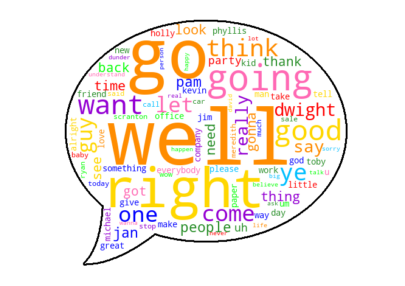

Wordcloud for Jim


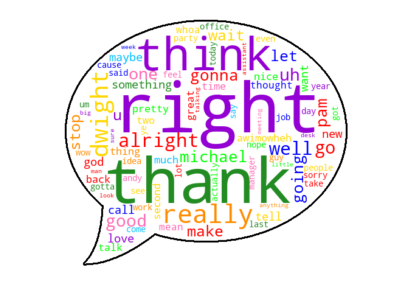

Wordcloud for Dwight


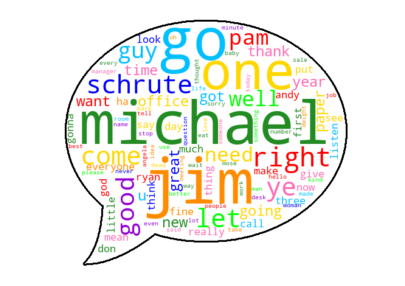

Wordcloud for Pam


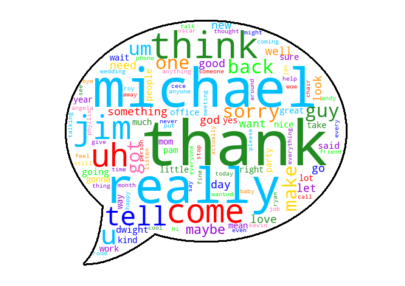

Wordcloud for Andy


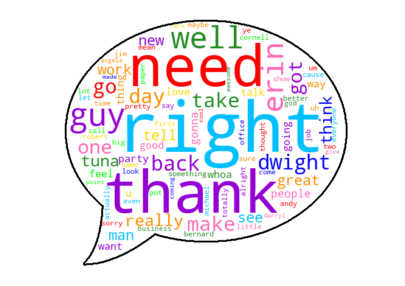

In [18]:
for character in characters_to_analyze:
    #output = get_toke_text_dialog(character)
    print(f"Wordcloud for {character}")
    make_wordcloud_image(character)

However, overall we found that the majority of words used in the dialogue, are, as expected, natural interaction language interactions that do not carry much meaning. 

### Michael

In michael's word cloud, we find the names of the people with whom he interacts the most frequently, such as Dwight, Pam and Jan. We also find "party", which fits well with his character's affinity for frequent parties.

### Dwight

We find that Dwight says "Michael" a lot, which is very intuitive given that Dwight very frequently screams Michaels name to complain after Jim makes a prank on him.


### Jim

Jim doesn't have many descriptive words. However, we do notice he is often quite sarcastic given the words "really", "right", "alright", though most of this aspect of his personality is reflected in his facial expressions.

### Pam

For Pam one can observe she mainly interacts with Michael in the office, since she is the secretary, and then with Jim. One can tell she is more insecure, with many words such as "think", "sorry", "um" or "uh".

### Andy

Finally, from Andy, one can see that he uses "right" a lot, which could make reference to him being a people-pleaser and agreeing to everything. We also see he interacts often with his girlfriend Erin.

## On the wiki pages

We use the pages from [The Office Wiki](https://theoffice.fandom.com/wiki/Main_Page), for each character to extract some descriptive adjectives and verbs that define the character's background, lifestyle and personality. Since we only have a document per character, we do a simple frequency count.

In [19]:
G = nx.readwrite.adjlist.read_adjlist("Data/GCC.gz")
surnames_and_names = "_".join(G.nodes()).split("_")
words_to_remove = ["episode", "season", "later", "character", "tell", "back", "one", "two", "often", "series", "airdate", "tv", "u", "networknbc", "fischer", "jenna"] + [c.lower() for c in surnames_and_names] + sw

We need to exlude areas that are not relevant and pollute the information. Unfortunetely, each page has different sections, so we have to define them manually.

In [20]:
start_end = {"Michael_Scott":
                         ("==Character information, arc, and backstory==",
                         "==Relationships=="),
             "Jim_Halpert":
                         ("",
                         "== Appearances=="), 
             "Dwight_Schrute":
                         ("== Character information ==",
                         "==Coworker Relations=="),
             "Pam_Beesly":
                         ("==Casting and character development==",
                         "==Appearances=="),
             "Andy_Bernard":
                         ("Biography",
                         "==Notes and trivia==")}


In [24]:
def get_token_text_wiki_page(character):
    f = open(f"Data/characters/{character}.txt", encoding="utf8")
    text = f.read() 
    start, end = start_end[character]
    text = text[text.index(start):text.index(end)]
    tokens = [token for token in tokenize_text(text) if token not in words_to_remove]
    return " ".join(tokens) 

In [25]:
def make_wordcloud(output, character):
      
    wordcloud = WordCloud(width = 1600, height= 800,max_words=150, background_color="white", min_font_size=10,collocations=False, contour_width=3, colormap=newcmp).generate(output)       
    plt.figure(figsize=[10,5])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.savefig(folder + f"{character}_wiki.png")
    #plt.title(f"Wordcloud for {character}")
    plt.show()

Wordcloud for Michael_Scott


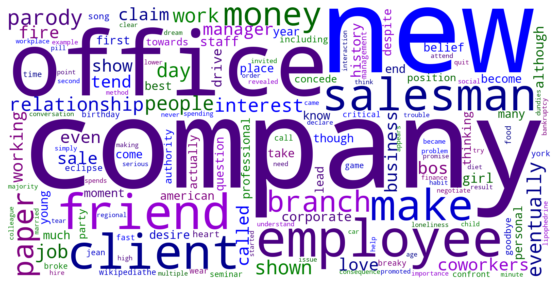

Wordcloud for Jim_Halpert


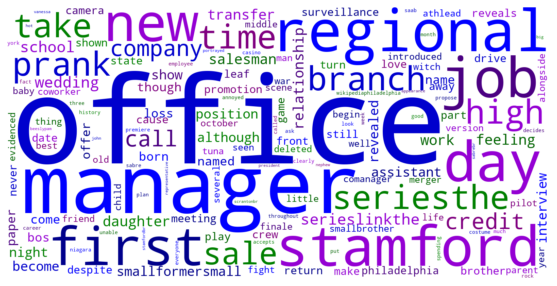

Wordcloud for Dwight_Schrute


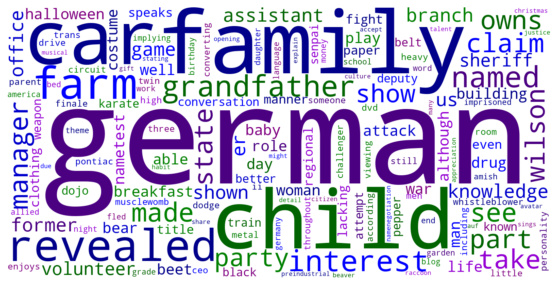

Wordcloud for Pam_Beesly


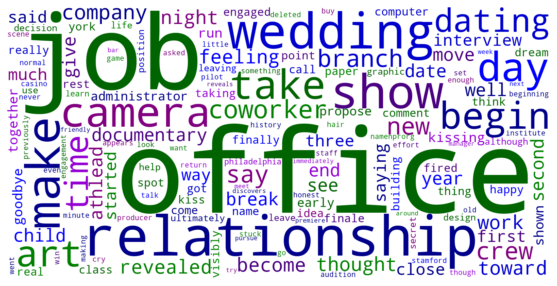

Wordcloud for Andy_Bernard


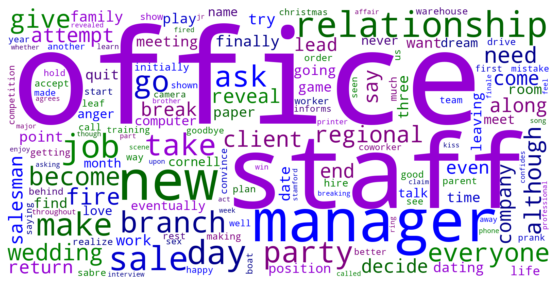

In [26]:
characters_to_analyze = ["Michael_Scott", "Jim_Halpert", "Dwight_Schrute", "Pam_Beesly", "Andy_Bernard"]

for character in characters_to_analyze:
    output = get_token_text_wiki_page(character)    
    print(f"Wordcloud for {character}")
    make_wordcloud(output,character)

### Michael

`Michael` has the words "parody", "manager", and "salesman". These words define his fondness for making parodies of characters, as well as his positions throughout his career at Dunder Mifflin. We also find the word "friend", potentially related to his deepest desire to make friendships at work.

### Dwight

For `Dwight` we see more descriptive words that match his ancestry, such as "german" and "amish", "farm" where he lives, and "sheriff", where he volunteers in his spare time. We also very interestingly see the words "family" and "child" amongst the most prominent words - which could be related to his relationship and child-rearing contract with Angela. There are even words related to his fighting instinct, such as "dodge", "attack", and "fight" and "war". 

### Jim

`Jim` has the words "stamford", a branch of Dunder Mifflin he was transferred to for some time. He also has "prank", since he is constantly pranking Dwight. Finally, he has some links to his family with Pam as well, such as "daughter" and "relationship".

### Pam
For `Pam` we see "art", which is her passion, and words that link her to Jim such as "wedding", "dating" or "relationship", and "child".

### Andy

Finally, for `Andy` we see "new", potentially linked to the fact that he joined the cast later than the other main characters, as many links to his job: "staff", "office", "manager", "job", "regional", "branch", and "sale". He also had the word "relationship", potentially related to Erin and his deep-rooted need to find love throughout his character arc. Lasly, we found "anger", which relates to his initial character traits of lacking anger management skills.

## Collocations

We tried to find collocations, but it wasn't very successfull, since we wanted longer phrases.

In [27]:
characters_to_analyze = ["michael", "pam", "jim", "dwight"]

In [28]:
def get_lines(character):
    path = "Data/character_lines/"
    text = []
    folder = path + character + "/"
    for file in os.listdir(folder):
        tsv_file = open(folder + file,encoding="utf8")
        read_tsv = csv.reader(tsv_file, delimiter="\n")

        text.append([row[0] for row in read_tsv])
        
    return text

In [29]:
def get_tokens(characters_to_analyze):
    characters_tokens = {}
    
    for character in characters_to_analyze:
        texts = get_lines(character)
        tokens = [tokenize_sentences(text) for text in texts]

        characters_tokens[character] = tokens
    return characters_tokens

In [38]:
p = punctuation.replace("'","")
for character in characters_to_analyze:
    #Text = " ".join(["".join(line) for line in get_lines(character)]).lower()
    x = " ".join([word.lower() for words in get_lines(character) for word in words])
    x = re.split(f'[{p}\s]+', x)
    Text = nltk.Text(x)
    print(f"Collocations for {character}")
    print("")
    Text.collocations()
    print("")
    print("------------")

Collocations for michael

dunder mifflin; michael scott; dont know; little bit; new york; hey
hey; conference room; beep beep; would like; david wallace; regional
manager; ice cream; paper company; blah blah; whoa whoa; yeah yeah;
okay okay; dont want; dont think; wait wait

------------
Collocations for pam

dunder mifflin; dont know; dont think; conference room; new york; feel
like; michael scott; good luck; sarah kaya; office administrator; pam
halpert; dont want; ben franklin; good morning; david wallace; okay
okay; paper company; ten minutes; ice cream; mmm hmm

------------
Collocations for jim

dont know; little bit; stop stop; whoa whoa; dunder mifflin; jim
halpert; regional manager; one second; new york; dont think; big deal;
feel like; conference room; dont worry; desert island; wait wait;
michael scott; years ago; really sorry; doesnt matter

------------
Collocations for dwight

dunder mifflin; dwight schrute; regional manager; hey hey; assistant
regional; ive got; dont kno